**Author: Antonio Moreno Martin**

### Import libraries

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from dateutil.relativedelta import relativedelta
import plotly.express as px
import seaborn as sns
import glob
import xgboost as xgb
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.graphics.tsaplots import plot_predict
from sklearn.metrics import mean_squared_error
from prophet import Prophet
import warnings
warnings.filterwarnings("ignore")

/Users/amm/Documents/miniconda3/envs/gasolina/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def create_features(df):
    '''
    Crearemos features de time series basados en el index para estudiar luego su comportamiento
    '''
    
    df = df.set_index('Fecha')
    df['month'] = df.index.month
    df['year'] = df.index.year
    
    return df

def plot_prediction(df_total, df):
    fig = make_subplots(rows=1, cols=1)


    train =df_total.loc[:(len(df)-1)]
    prediction = df_total.loc[(len(df)-1):]
    prediction

    fig.add_trace(
        go.Line(name = "Precio Real", x = train.Fecha, y = train.Precio),
        row=
        1, col=1
    )
    fig.add_trace(        
        go.Line(name = "Precio Predicho", x = prediction.Fecha, y = prediction.Precio),
        row=
        1, col=1
    )
    fig
    fig.show()

### Read and gather downloaded data

In [3]:
# Leer y gather data
input = "/Users/amm/Documents/Github/Data/Gasolina/source/Madrid_alcampo_gasolina_98_E5/"
files = glob.glob(input + '*.xls')

df = pd.concat([pd.read_excel(file) for file in files], ignore_index=True)

df['Fecha'] = pd.to_datetime(df['Fecha'])
df.sort_values(by='Fecha', inplace = True)

### <mark> Define dates to train and test </mark>

In [4]:
time_train = '2023-04-01' # This is the last date of the train
time_test = '2023-12-01' # This is the last date of the test
time_to_predict = (datetime.strptime(time_train, '%Y-%m-%d')+ relativedelta(months=1)).strftime('%Y-%m-%d') # we add one month to start the prediction and convert back to string
df_train = df[df['Fecha']<=time_train]
df_test = df[df['Fecha']>time_train]
df_train

,Fecha,Precio
0,2012-01-01,1.433129
1,2012-02-01,1.442482
2,2012-03-01,1.471516
3,2012-04-01,1.500266
4,2012-05-01,1.455064
...,...,...
131,2022-12-01,1.639903
132,2023-01-01,1.619419
133,2023-02-01,1.648428
134,2023-03-01,1.654032


In [5]:

fig = px.line(df, x = 'Fecha', y = 'Precio', title = 'Gasolina 98 E5 Madrid 2020 - 2023')
fig.show()

In [6]:

df_study = create_features(df)
fig = px.box(df_study, x= "month", y="Precio")
fig.show()

In [7]:

# Determinar si es un random walk o no
# Vamos a determinar si es un random walk o no. Recordar que es un proceso donde hay mismas posibilidades tanto de ir hacia arriba o hacia abajo por un número aleatorio.
# Step 1: Ver si existe una tendencia. En este caso, parece que puede haberlo ya que año a año ha ido incrementando.
## 1.a Vamos a descomponerlo en tendencia, temporalidad y residuos

In [8]:
advanced_decomposition = STL(df['Precio'], period = 12).fit()

fig = make_subplots(rows=4, cols=1, subplot_titles=("Observed", "Trend", "Seasonal", "Residuals"))

fig.add_trace(
    go.Line(name = "Valores reales", x = df.Fecha, y = advanced_decomposition.observed),
    row=1, col=1
)
fig.add_trace(
    go.Line(name = "Tendencia", x = df.Fecha, y = advanced_decomposition.trend),
    row=2, col=1
)
fig.add_trace(
    go.Line(name = "Componente Estacional", x = df.Fecha, y = advanced_decomposition.seasonal),
    row=3, col=1
)
fig.add_trace(
    go.Line(name = "Residuos", x = df.Fecha, y = advanced_decomposition.resid),
    row=4, col=1
)

/Users/amm/Documents/miniconda3/envs/gasolina/lib/python3.11/site-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




Efectivamente, vemos una tendencia en la segunda gráfica. Vamos a salir de dudas con test ADF para ver el ACF(Autocorrelation function):

ADF Statistic: -2.064883703276379
p-value: 0.2588673794418084


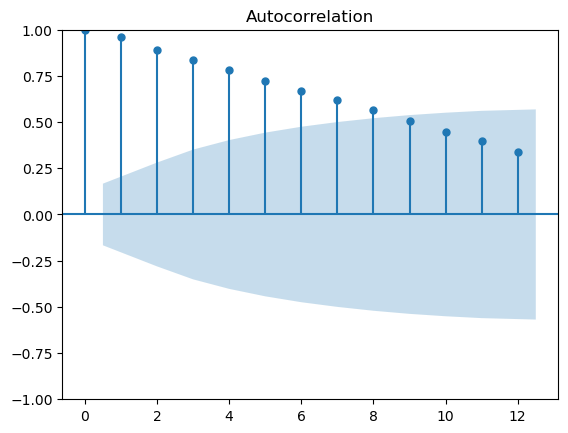

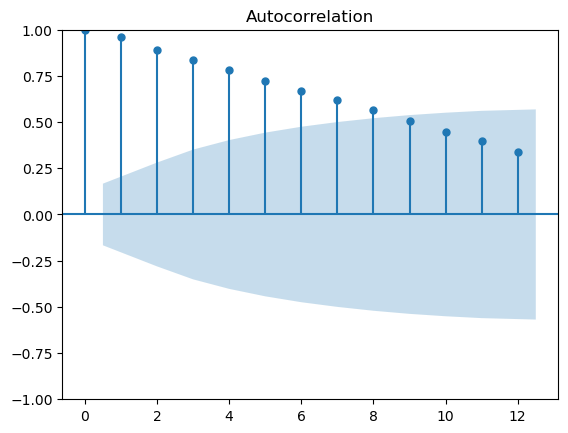

In [9]:
ADF_result = adfuller(df.Precio)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

plot_acf(df.Precio, lags=12) # Vemos como hay una relación linela en las muestras y por tanto, es no estacionario. Dentro del confidence interval se considera que es como tener 

Como el p valores mayor que 0.05, no podemos rechazar la null hyphotesis y por tanto es no estacionacionaria. Por ende, tennemos que volver a diferenciar por primera vez.

## Plot ACF

### Aplicar Dickey-Fuller test (ADF)  para saber si es temporal o no

ADF Statistic: 0.009352999999999945
p-value: 0.029034000000000004


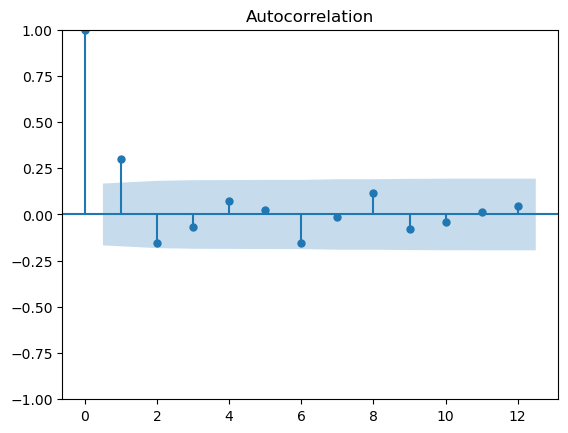

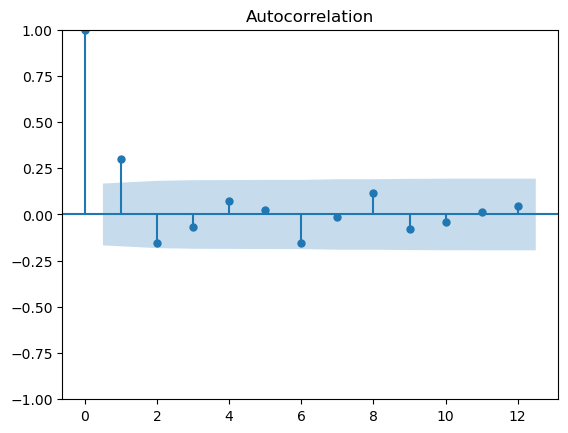

In [10]:

diff_gasolina = np.diff(df['Precio'], n = 1)
print(f'ADF Statistic: {diff_gasolina[0]}')
print(f'p-value: {diff_gasolina[1]}')
plot_acf(diff_gasolina, lags = 12) 



In [11]:
ADF_result = adfuller(diff_gasolina)
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -8.974237215558928
p-value: 7.607970424187538e-15


**p valor menor que 0,05 y un ADF negativo no muy grande => por tanto, podemos rechazar la hipotesis nula y decir que es <mark>estacional</mark>**

Vemos como tiene un comportamiento <mark> SINUSOIDAL pattern</mark> 

# Moving Average (MA)

<mark>Uno de los motivos por los que hariamos MA, sería al dibujar el PACF (funcion parcial de autocorrelacion), donde tendríamos que ver un decay LINEAL. Recordamos que el MA era decay exponencial</mark>

In [12]:
df_aux = df.copy()
df_aux = df_aux.set_index('Fecha')


In [13]:
df_aux = df.copy()
df_aux = df_aux.set_index('Fecha')

train = df_aux.loc[df_aux.index <= time_train]
test = df_aux.loc[df_aux.index > time_train]
train

,Precio
Fecha,
2012-01-01,1.433129
2012-02-01,1.442482
2012-03-01,1.471516
2012-04-01,1.500266
2012-05-01,1.455064
...,...
2022-12-01,1.639903
2023-01-01,1.619419
2023-02-01,1.648428


In [14]:
diff_train = np.diff(train['Precio'], n = 1)
indices_diff = train[1:].index.tolist()
df_diff = pd.DataFrame({'diff_gasolina': diff_train})
df_diff.index = indices_diff
df_diff


,diff_gasolina
2012-02-01,0.009353
2012-03-01,0.029034
2012-04-01,0.028750
2012-05-01,-0.045202
2012-06-01,-0.053198
...,...
2022-12-01,-0.192230
2023-01-01,-0.020484
2023-02-01,0.029009
2023-03-01,0.005604


In [15]:
mod = ARIMA(df_diff, order=(0,0,1))
res = mod.fit()

predict_ma = res.get_prediction(start = time_to_predict, end = time_test)
prediction_ma = pd.DataFrame( columns=['predicted_MA'])

### <mark>`len(df) - 1`</mark> se pone ya que cuando diferenciamos, el primer elemento se pierde, y por tanto, no podemos considerar el primer elemento que se encuentra en el lag 0

In [16]:
df_pred = pd.DataFrame({'Fecha':predict_ma.predicted_mean.index, 'Precio':predict_ma.predicted_mean.values})
df_ma = pd.concat([df_train, df_pred])
df_ma = df_ma.reset_index(drop=True)

df_ma['Precio'].loc[(len(df_train)-1):,] = df_ma['Precio'][(len(df_train)-1):].cumsum()
df_ma


,Fecha,Precio
0,2012-01-01,1.433129
1,2012-02-01,1.442482
2,2012-03-01,1.471516
3,2012-04-01,1.500266
4,2012-05-01,1.455064
...,...,...
139,2023-08-01,1.616937
140,2023-09-01,1.618266
141,2023-10-01,1.619595
142,2023-11-01,1.620924


## PLOT MA PREDICTION

In [17]:
plot_prediction(df_ma, df_train)

/Users/amm/Documents/miniconda3/envs/gasolina/lib/python3.11/site-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




### Calculate the error with the predictions made

## MSE

- El <mark>len(df)</mark> del modelo con el que hemos construido el MA es en este momento <mark>136</mark>, por ello, para calcular el error compararemos hasta ese número

In [18]:
mse_ma = mean_squared_error(df_test['Precio'].loc[list(df_test.index)], df_ma['Precio'].loc[list(df_test.index)])
mse_ma

0.0054899778838488275

# AUTOREGRESSIVE MODEL (AR)

<mark>Al igual que para MA, es necesario dibujar su ACF, pero esta ve en lugar de decaer linealmente, deberíamos cerciorarnos de que decae exponencialmente<br>
Por otra parte, a DIFERENCIA de MA, para conocer su grado MA(p), NO nos basta  con el ACF, en este caso debemos dibujar el PACF y ver donde deja de haber coeficientes no significativos</mark>

## Plot PACF

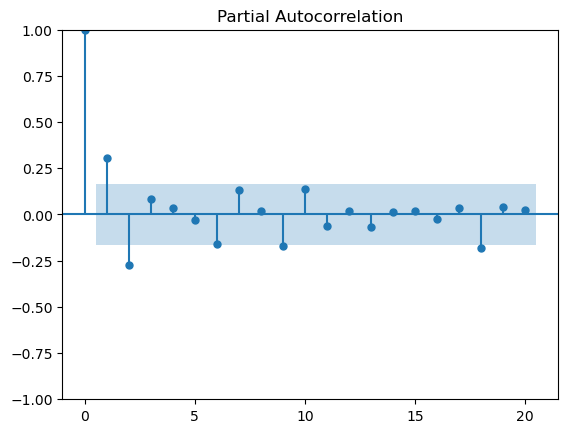

In [19]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(diff_gasolina, lags=20);

<mark>Vemos, que a partir del lag 2, los coeficientes dejan de ser significativos, por ende, estamos frente a un AR(2)
<br>
Además, cabe destacar que tiene al igual que el ACF, un comportamiento sinusoidal, por ende, podemos aplicar un modelo ARMA</mark>

In [20]:
mod = ARIMA(df_diff, order=(2,0,0)) # AR(2)
res = mod.fit()

predict_ar = res.get_prediction(start = time_to_predict, end = time_test)
prediction_ar = pd.DataFrame( columns=['predicted_AR'])

In [21]:
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:          diff_gasolina   No. Observations:                  135
Model:                 ARIMA(2, 0, 0)   Log Likelihood                 226.202
Date:                Sat, 01 Jul 2023   AIC                           -444.405
Time:                        17:24:49   BIC                           -432.784
Sample:                    02-01-2012   HQIC                          -439.682
                         - 04-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.005      0.266      0.790      -0.008       0.011
ar.L1          0.3851      0.052      7.346      0.000       0.282       0.488
ar.L2         -0.2695      0.048     -5.664      0.0

- const = 0 y ar.L1 0.3 es igual a phi=0.3 en la ecuación matemática

In [22]:
print(res.params)

const     0.001332
ar.L1     0.385139
ar.L2    -0.269515
sigma2    0.002047
dtype: float64


In [23]:
df_pred =pd.DataFrame({'Fecha':predict_ar.predicted_mean.index, 'Precio':predict_ar.predicted_mean.values})
df_ar = pd.concat([df_train, df_pred])
df_ar = df_ar.reset_index(drop=True)

df_ar['Precio'].loc[(len(df_train)-1):,] = df_ar['Precio'][(len(df_train)-1):].cumsum()
df_ar


,Fecha,Precio
0,2012-01-01,1.433129
1,2012-02-01,1.442482
2,2012-03-01,1.471516
3,2012-04-01,1.500266
4,2012-05-01,1.455064
...,...,...
139,2023-08-01,1.627420
140,2023-09-01,1.627875
141,2023-10-01,1.628623
142,2023-11-01,1.629966


## PLOT AR PREDICTION

In [24]:
plot_prediction(df_ar, df_train)

/Users/amm/Documents/miniconda3/envs/gasolina/lib/python3.11/site-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




## MSE

In [25]:
mse_ar = mean_squared_error(df_test['Precio'].loc[list(df_test.index)], df_ar['Precio'].loc[list(df_test.index)])
mse_ar

0.005998863064676289

# AUTOREGRESSIVE MOVING AVERAGE (ARMA)

<mark>Para identificar si es un ARMA, tenemos que visualizar unos patrones sinusoidales o un patrón decaying TANTO en el ACF Y PACF por el cual no haya un claro lag donde se vuelva abruptamente no significante.</mark>

Referencia:
<br>
<br>
https://www.statsmodels.org/dev/examples/notebooks/generated/tsa_arma_0.html
<br>
<br>
<mark> En funcion ARIMA(p, d, q) los parámetros que podemos rellenar para usar un ARMA son p y q, por ende, la d tiene que ser igual a cero cuando construyamos un ARMA model </mark>


En nuestro caso, podemos ver como en ambos casos es sinusoidal, así que procederemos a aplicar un ARMA

## AIC to create the model

In [26]:
def create_opt_ARIMA(df_to_predict, grades, d):
    '''
    Función para fittear distintos ARMAS o ARIMAS con todas las combinaciones de grades que le indicaremos, eligiendo el modelo más óptimo (viendo su AIC)
    Si queremos crear un ARMA, habrá que poner la 'd' a cero.
    
    df_to_predict: pandas dataframe
        Es el df ya tratado previamente para poder aplicarle el modelo ARMA y predecir
    
    grades: int MAYOR QUE CERO
        Creará una lista de 0 hasta grades
        
    '''
    grades = list(range(0,grades + 1))
    arma_mods = [ARIMA(df_to_predict, order=(p, d, q)).fit() for q in grades for p in grades]
    aic = [arma.aic for arma in arma_mods]
    ar = [list(arma.model_orders.values())[2]for arma in arma_mods] # Elegimos el valor 2, ya que en model_orders, es donde se encuentra el parametro p correspondiente al ar
    ma = [list(arma.model_orders.values())[3]for arma in arma_mods]
    
    df_armas = pd.DataFrame(data = zip(ar, ma, aic), columns = ["p", "q", "AIC"])
    df_armas = df_armas.sort_values("AIC") # Ordenamos de MENOR a MAYOR, ya que el menor AIC  
    return df_armas, arma_mods

<mark>The lower the value for AIC, the better the fit of the model. The absolute value of the AIC value is not important. It can be positive or negative.</mark>
<br>
<br>
**Reference**: https://www.statology.org/negative-aic/

In [27]:
df_armas, arma_mods = create_opt_ARIMA(df_diff, 3, 0)
df_armas

,p,q,AIC
10,2,2,-445.746538
14,2,3,-444.629162
4,0,1,-444.499983
2,2,0,-444.404860
3,3,0,-443.536180
8,0,2,-443.486242
6,2,1,-443.270504
5,1,1,-443.113100
12,0,3,-443.010493
9,1,2,-442.897489


In [28]:
# Seleccionamos el primer modelo al ser el que tiene menor AIC, por eso elegimos el [0]
arma_model = arma_mods[df_armas.index.tolist()[0]]
arma_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:          diff_gasolina   No. Observations:                  135
Model:                 ARIMA(2, 0, 2)   Log Likelihood                 228.873
Date:                Sat, 01 Jul 2023   AIC                           -445.747
Time:                        17:24:52   BIC                           -428.315
Sample:                    02-01-2012   HQIC                          -438.663
                         - 04-01-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.005      0.284      0.776      -0.008       0.011
ar.L1         -0.4004      0.080     -5.031      0.000      -0.556      -0.244
ar.L2         -0.8118      0.085     -9.589      0.000      -0.978      -0.646
ma.L1          0.6925      0.094      7.364      0.000       0.508       0.877
ma.L2          0.9051      0.079     11.445      0.000       0.750       1.060
sigma2         0.0019      0.000     12.568      0.000       0.002       0.002
===================================================================================
Ljung-Box (L1) (Q):                   1.78   Jarque-Bera (JB):               232.25
Prob(Q):                              0.18   Prob(JB):                         0.00
Heteroskedasticity (H):               3.69   Skew:                             0.62
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Model's residuals

Hasta este punto, viendo el AIC, nos damos cuenta que el mejor modelo es el ARMA(2,2). Ahora, debemos <mark>analizar los residuos</mark>, que no dejan de ser la diferencia entre el valor real
<br> y el predicho para ver que dicha diferencia no es random. Eso se mira a través del <mark>QQplot</mark> y corriendo el <mark>Ljung-Boxtest</mark>

In [29]:
residuals = arma_model.resid
residuals

2012-02-01    0.008021
2012-03-01    0.026093
2012-04-01    0.022400
2012-05-01   -0.047101
2012-06-01   -0.038257
                ...   
2022-12-01   -0.110109
2023-01-01   -0.011642
2023-02-01   -0.030477
2023-03-01    0.029285
2023-04-01    0.002084
Length: 135, dtype: float64

### QQ-PLOT

Es una herramienta gráfica para verificar la hipotesis de que nuestro model's residuals tiene distribución normal.
<br> Si el scatterplot se superpone a la lineal, diremos que tiene buen fit 

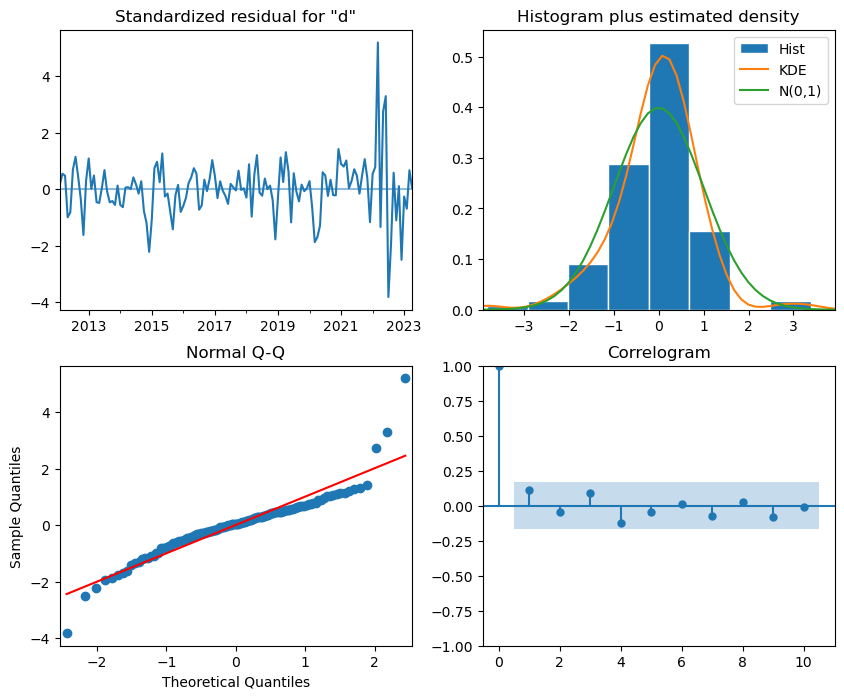

In [30]:
arma_model.plot_diagnostics(figsize=(10, 8));

In [31]:
arma_predict = arma_model.get_prediction(start = time_to_predict, end = time_test)

In [32]:
df_pred = pd.DataFrame({'Fecha':arma_predict.predicted_mean.index, 'Precio':arma_predict.predicted_mean.values})
df_arma = pd.concat([df_train, df_pred])
df_arma = df_arma.reset_index(drop=True)

df_arma['Precio'].loc[(len(df_train)-1):,] = df_arma['Precio'][(len(df_train)-1):].cumsum()
df_arma


,Fecha,Precio
0,2012-01-01,1.433129
1,2012-02-01,1.442482
2,2012-03-01,1.471516
3,2012-04-01,1.500266
4,2012-05-01,1.455064
...,...,...
139,2023-08-01,1.649317
140,2023-09-01,1.676407
141,2023-10-01,1.663805
142,2023-11-01,1.649806


## PLOT ARMA PREDICTION

In [33]:
plot_prediction(df_arma, df_train)

/Users/amm/Documents/miniconda3/envs/gasolina/lib/python3.11/site-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




## MSE

In [34]:
mse_arma = mean_squared_error(df_test['Precio'].loc[list(df_test.index)], df_arma['Precio'].loc[list(df_test.index)])
mse_arma

0.016950311231424223

# AUTOREGRESSIVE INTEGRATED MOVING AVERAGE MODEL (ARIMA)

Añadiremos una componente a ARMA llamada el integration order denotado con la letra d. Con esta componente evitaremos tener en cuenta la no estacionalidad de las time series y evitar los pasos de transformación y diferenciación. Esta componente es simplemente la inversa de la diferenciación. <mark>Por ende, el orden de integración es igual al número de veces que una serie ha sido diferenciada hasta que se ha vuelto estacional. Por ejemplo, si diferenciamos una serie dos veces y se vuelve estacional d=2</mark>
<br>
<br>
<mark>Resumiendo, el modelo ARIMA es como un modelo ARMA que puede ser aplicado en una serie no temporal sin necesidad de hacer todas las transformaciones que hacíamos, simplemente, ahora, tenemos que encontrar el orden de integración necesario para hacer la serie estacional </mark>

### Primer paso

Tenemos que conocer el orden de diferenciación hasta que nuestra serie sea estacional. Por ello, iríamos aplicando el test de Dickey-Fuller a cada serie hasta que podamos rechazar la hipotesis nula y decir que es estacional (siempre que la serie original no fuese estacional).
<br>
<br>
**Como dicho trabajo ya lo hemos hecho previamente, sabemos que el orden de diferenciación es en este caso 1 => d = 1**

In [35]:
def create_opt_ARIMA(df_to_predict, grades, d):
    '''
    Función para fittear distintos ARMAS o ARIMAS con todas las combinaciones de grades que le indicaremos, eligiendo el modelo más óptimo (viendo su AIC)
    Si queremos crear un ARMA, habrá que poner la 'd' a cero.
    
    df_to_predict: pandas dataframe
        Es el df ya tratado previamente para poder aplicarle el modelo ARMA y predecir
    
    grades: int MAYOR QUE CERO
        Creará una lista de 0 hasta grades
        
    d: orden de diferenciacion, cuantas veces hay que diferenciar la serie para hacerla estacional
        
    '''
    grades = list(range(0,grades + 1))
    arma_mods = [ARIMA(df_to_predict, order=(p, d, q)).fit() for q in grades for p in grades]
    aic = [arma.aic for arma in arma_mods]
    ar = [list(arma.model_orders.values())[2]for arma in arma_mods] # Elegimos el valor 2, ya que en model_orders, es donde se encuentra el parametro p correspondiente al ar
    ma = [list(arma.model_orders.values())[3]for arma in arma_mods]
    
    df_armas = pd.DataFrame(data = zip(ar, ma, aic), columns = ["p", "q", "AIC"])
    df_armas = df_armas.sort_values("AIC") # Ordenamos de MENOR a MAYOR, ya que el menor AIC  
    return df_armas, arma_mods

In [36]:
df_arimas, arima_mods = create_opt_ARIMA(df_diff, 3, d = 1)
df_arimas

,p,q,AIC
15,3,3,-439.136660
14,2,3,-436.766115
8,0,2,-436.004143
6,2,1,-435.412361
12,0,3,-434.785445
7,3,1,-434.732306
9,1,2,-434.503788
10,2,2,-434.373368
13,1,3,-433.422928
11,3,2,-431.619242


In [37]:
# Seleccionamos el primer modelo al ser el que tiene menor AIC, por eso elegimos el [0]
arima_model = arima_mods[df_arimas.index.tolist()[0]]
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:          diff_gasolina   No. Observations:                  135
Model:                 ARIMA(3, 1, 3)   Log Likelihood                 226.568
Date:                Sat, 01 Jul 2023   AIC                           -439.137
Time:                        17:24:56   BIC                           -418.852
Sample:                    02-01-2012   HQIC                          -430.894
                         - 04-01-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1967      0.082     -2.409      0.016      -0.357      -0.037
ar.L2         -0.8343      0.060    -13.885      0.000      -0.952      -0.717
ar.L3          0.2316      0.100      2.316      0.021       0.036       0.428
ma.L1         -0.3890      3.985     -0.098      0.922      -8.200       7.422
ma.L2          0.3805      2.393      0.159      0.874      -4.310       5.071
ma.L3         -0.9913      4.032     -0.246      0.806      -8.894       6.911
sigma2         0.0019      0.008      0.247      0.805      -0.013       0.017
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):               205.10
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               3.78   Skew:                             0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

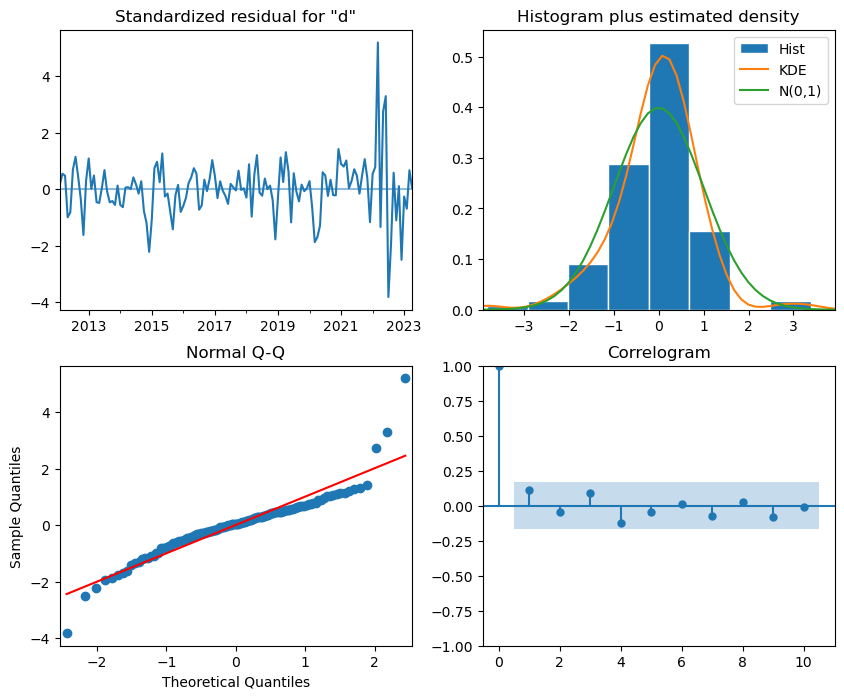

In [38]:
arma_model.plot_diagnostics(figsize=(10, 8));

In [39]:
arima_predict = arima_model.get_prediction(start = time_to_predict, end = time_test)
prediction_arima = pd.DataFrame( columns=['predicted_ARIMA'])

In [40]:
df_pred = pd.DataFrame({'Fecha':arima_predict.predicted_mean.index, 'Precio':arima_predict.predicted_mean.values})
df_arima = pd.concat([df_train, df_pred])
df_arima = df_arima.reset_index(drop=True)

df_arima['Precio'].loc[(len(df_train)-1):,] = df_arima['Precio'][(len(df_train)-1):].cumsum()
df_arima


,Fecha,Precio
0,2012-01-01,1.433129
1,2012-02-01,1.442482
2,2012-03-01,1.471516
3,2012-04-01,1.500266
4,2012-05-01,1.455064
...,...,...
139,2023-08-01,1.652509
140,2023-09-01,1.695927
141,2023-10-01,1.672887
142,2023-11-01,1.646232


## PLOT ARIMA PREDICTION

In [41]:
plot_prediction(df_arima, df_train)

/Users/amm/Documents/miniconda3/envs/gasolina/lib/python3.11/site-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




## MSE

In [43]:
mse_arima = mean_squared_error(df_test['Precio'].loc[list(df_test.index)], df_arima['Precio'].loc[list(df_test.index)])
mse_arima

0.019998110379645082

# SEASONAL AUTOREGRESSIVE INTEGRATED MOVING AVERAGE MODEL (SARIMA)

Tendremos 3 parámetros nuevos frente al modelo ARIMA, y un parámetro m representando la frecuencia de la estacionalidad de la serie.
En nuestro caso, no se ve gráficamente unos patrones de estacionalidad, por lo cual, es interesante volver al dibujo de decomposición que hicimos al principio. No se ve claramente un patrón, pero sí es cierto que los dos últimos años parece haber patrones. Por motivos prácticos, asumiremos una frecuencia de 12 representando los 12 meses de un año de periodicidad.

In [44]:
def create_opt_SARIMA(df_to_predict, grades, d, f):
    '''
    Función para fittear distintos SARIMA con todas las combinaciones de grades que le indicaremos, eligiendo el modelo más óptimo (viendo su AIC)
    Si queremos crear un ARMA, habrá que poner la 'd' a cero.
    
    df_to_predict: pandas dataframe
        Es el df ya tratado previamente para poder aplicarle el modelo ARMA y predecir
    
    grades: int MAYOR QUE CERO
        Creará una lista de 0 hasta grades
    
    d: orden de diferenciacion, cuantas veces hay que diferenciar la serie para hacerla estacional
    
    f: frecuencia de la periodicidad
        
    '''
    grades = list(range(0,grades + 1))
    D = 0 
    #https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAXResults.html
    arma_mods = [SARIMAX(df_to_predict, order=(p, d, q), seasonal_order = (P, D, Q, f)).fit(disp = False) for q in grades for p in grades for P in grades for Q in grades]
    aic = [arma.aic for arma in arma_mods]
    ar = [list(arma.model_orders.values())[2]for arma in arma_mods] # Elegimos el valor 2, ya que en model_orders, es donde se encuentra el parametro p correspondiente al ar
    ma = [list(arma.model_orders.values())[3]for arma in arma_mods]
    s_ar = [list(arma.model_orders.values())[4]for arma in arma_mods] 
    s_ma = [list(arma.model_orders.values())[5]for arma in arma_mods] 
    
    df_armas = pd.DataFrame(data = zip(ar, ma, s_ar, s_ma, aic), columns = ["p","q", "P",  "Q", "AIC"])
    df_armas = df_armas.sort_values("AIC") # Ordenamos de MENOR a MAYOR, ya que el menor AIC  
    return df_armas, arma_mods

In [45]:
import pickle
import os

In [46]:
os.getcwd()

'/Users/amm/Documents/Github/Precios Gasolina'

In [47]:
update = False # Si el modelo ya ha sido creado, hacemos load poniendo update = False, de lo contrarios, construimos el modelo de 0 poniendo update = True
if update == True:
    df_sarimas, sarima_mods = create_opt_SARIMA(df_diff, 8, d = 1, f = 12)
    
    # Seleccionamos el primer modelo al ser el que tiene menor AIC, por eso elegimos el [0]
    sarima_model = sarima_mods[df_sarimas.index.tolist()[0]]
    sarima_model.summary()
    sarima_model.save('sarima_v2.pkl')
else: 
    sarima_model = pickle.load(open('sarima_v1.pkl', 'rb'))
    print(sarima_model.summary())

                                           SARIMAX Results                                           
Dep. Variable:                                 diff_gasolina   No. Observations:                  135
Model:             SARIMAX(3, 1, 3)x(0, 0, [1, 2, 3, 4], 12)   Log Likelihood                 231.801
Date:                                       Sat, 01 Jul 2023   AIC                           -441.601
Time:                                               17:25:39   BIC                           -409.725
Sample:                                           02-01-2012   HQIC                          -428.648
                                                - 04-01-2023                                         
Covariance Type:                                         opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2986     

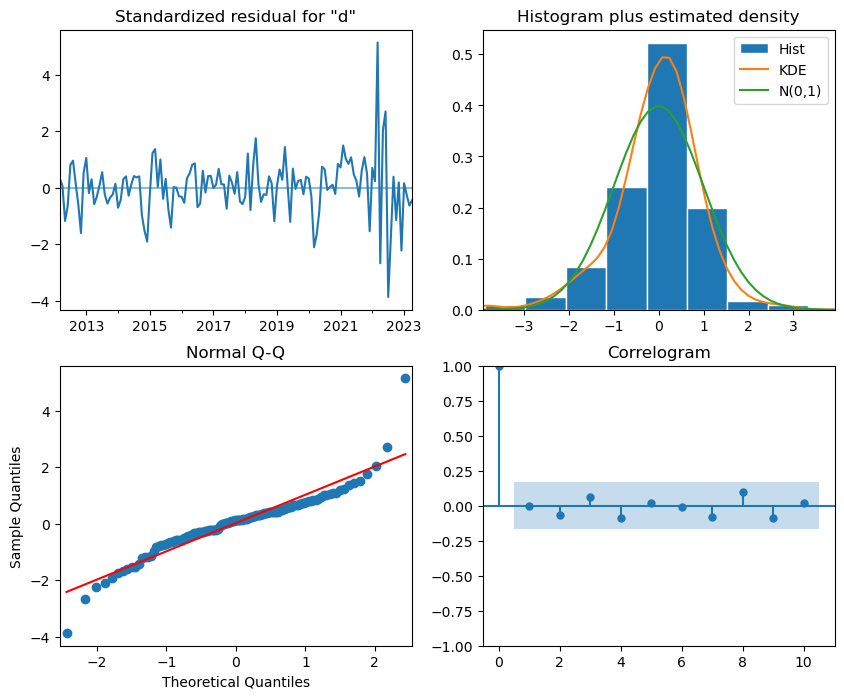

In [48]:
sarima_model.plot_diagnostics(figsize=(10, 8));

In [49]:
sarima_predict = sarima_model.get_prediction(start = time_to_predict, end = time_test)
prediction_sarima = pd.DataFrame( columns=['predicted_SARIMA'])

In [50]:
df_pred = pd.DataFrame({'Fecha':sarima_predict.predicted_mean.index, 'Precio':sarima_predict.predicted_mean.values})
df_sarima = pd.concat([df_train, df_pred])
df_sarima = df_sarima.reset_index(drop=True)

df_sarima['Precio'].loc[(len(df_train)-1):,] = df_sarima['Precio'][(len(df_train)-1):].cumsum()
df_sarima


,Fecha,Precio
0,2012-01-01,1.433129
1,2012-02-01,1.442482
2,2012-03-01,1.471516
3,2012-04-01,1.500266
4,2012-05-01,1.455064
...,...,...
139,2023-08-01,1.599487
140,2023-09-01,1.619091
141,2023-10-01,1.588646
142,2023-11-01,1.562688


## PLOT SARIMA PREDICTION

In [51]:
plot_prediction(df_sarima, df_train)

/Users/amm/Documents/miniconda3/envs/gasolina/lib/python3.11/site-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




## MSE

In [52]:
mse_sarima = mean_squared_error(df_test['Precio'].loc[list(df_test.index)], df_sarima['Precio'].loc[list(df_test.index)])
mse_sarima

0.01805895839209764

## MSE Competition

In [53]:
def plot_prediction(df_total, df):
    fig = make_subplots(rows=1, cols=1)


    train =df_total.loc[:(len(df)-1)]
    prediction = df_total.loc[(len(df)-1):]
    prediction

    fig.add_trace(
        go.Line(name = "Precio Real", x = train.Fecha, y = train.Precio),
        row=
        1, col=1
    )
    fig.add_trace(        
        go.Line(name = "Precio Predicho", x = prediction.Fecha, y = prediction.Precio),
        row=
        1, col=1
    )
    fig
    fig.show()

In [54]:
df_mse = pd.DataFrame(columns = ['Model', 'MSE'])
df_mse.loc[0]= ['MA', mse_ma]
df_mse.loc[1]= ['AR', mse_ar]
df_mse.loc[2]= ['ARMA', mse_arma]
df_mse.loc[3]= ['ARIMA', mse_arima]
df_mse.loc[4]= ['SARIMA', mse_sarima]
df_mse

,Model,MSE
0,MA,0.005490
1,AR,0.005999
2,ARMA,0.016950
3,ARIMA,0.019998
4,SARIMA,0.018059


In [55]:
fig_mse = px.bar(df_mse, x='Model', y='MSE', title= 'Competeción MSE de los modelos construidos')
fig_mse.show()


# Prophet

In [56]:
m = Prophet()

In [58]:
train_prophet = df_train.copy()
train_prophet.columns = ['ds', 'y'] # Prophet nos obliga a tener esta nomenclatura de columnas
train_prophet.head()

,ds,y
0,2012-01-01,1.433129
1,2012-02-01,1.442482
2,2012-03-01,1.471516
3,2012-04-01,1.500266
4,2012-05-01,1.455064


In [59]:
m.fit(train_prophet);

17:25:46 - cmdstanpy - INFO - Chain [1] start processing
17:25:46 - cmdstanpy - INFO - Chain [1] done processing


In [126]:
future = m.make_future_dataframe(periods = 365)
forecast = m.predict(future)
forecast.head(3)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2012-01-01,1.508561,1.349265,1.586216,1.508561,1.508561,-0.044162,-0.044162,-0.044162,-0.044162,-0.044162,-0.044162,0.0,0.0,0.0,1.464399
1,2012-02-01,1.503212,1.347112,1.578140,1.503212,1.503212,-0.046835,-0.046835,-0.046835,-0.046835,-0.046835,-0.046835,0.0,0.0,0.0,1.456377
2,2012-03-01,1.498208,1.384268,1.614539,1.498208,1.498208,-0.000821,-0.000821,-0.000821,-0.000821,-0.000821,-0.000821,0.0,0.0,0.0,1.497387


In [118]:
dates_to_pred = df_arima['Fecha'].tolist()
pred_to = forecast.copy()
pred_to = forecast[forecast['ds'].isin(dates_to_pred)][['ds', 'yhat']]
pred_to.columns = ['Fecha', 'Precio']
pred_to

,Fecha,Precio
0,2012-01-01,1.464399
1,2012-02-01,1.456377
2,2012-03-01,1.497387
3,2012-04-01,1.506096
4,2012-05-01,1.497230
...,...,...
257,2023-08-01,1.854147
288,2023-09-01,1.858903
318,2023-10-01,1.903442
349,2023-11-01,1.934757


In [107]:
test_prophet = df_test.copy()
test_prophet[['yhat', 'yhat_lower', 'yhat_upper']]  = forecast[['yhat', 'yhat_lower', 'yhat_upper']] 
test_prophet

,Fecha,Precio,yhat,yhat_lower,yhat_upper
136,2023-05-01,1.534645,1.809134,1.697047,1.928830
137,2023-06-01,1.544650,1.836434,1.717052,1.950993


In [119]:
plot_prediction(pred_to, df_train)

/Users/amm/Documents/miniconda3/envs/gasolina/lib/python3.11/site-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




In [ ]:
mse_prophet = mean_squared_error(test_prophet['Precio'], test_prophet['yhat'])
df_mse = pd.DataFrame(columns = ['Model', 'MSE'])
df_mse.loc[0]= ['MA', mse_ma]
df_mse.loc[1]= ['AR', mse_ar]
df_mse.loc[2]= ['ARMA', mse_arma]
df_mse.loc[3]= ['ARIMA', mse_arima]
df_mse.loc[4]= ['SARIMA', mse_sarima]
df_mse.loc[4]= ['Prophet', mse_prophet]
df_mse

In [ ]:
fig_mse = px.bar(df_mse, x='Model', y='MSE', title= 'Competeción MSE de los modelos construidos')
fig_mse.show()